# Hebrew LLM Test

In [ ]:
pip install requests google-generativeai

## Winograd

In [ ]:
import json
import time
import requests
from typing import List, Dict


# =========================
# CONFIG
# =========================
API_KEY = "YOUR API KEY"
DATASET_PATH = "winograd_he.jsonl"

API_URL = "https://api.perplexity.ai/chat/completions"
MODEL_NAME = "sonar-pro"   # אפשר גם sonar-small / sonar-medium
TEMPERATURE = 0.0
SLEEP_BETWEEN_CALLS = 1.0  # הגנה מ-rate limit


# =========================
# FEW-SHOT PROMPT
# =========================
FEW_SHOT_PROMPT = """אתה מבצע מבחן הבנת שפה מסוג Winograd בעברית.

בכל שאלה:
- יופיע משפט
- תישאל שאלה
- יוצגו שתי אפשרויות תשובה

עליך לבחור איזו אפשרות היא התשובה הנכונה.
ענה רק בטקסט של אחת האפשרויות, ללא הסבר.

דוגמה 1:
משפט: הילד לא הצליח להרים את התרמיל כי הוא היה כבד מדי.
שאלה: מה היה כבד מדי?
אפשרות 1: הילד
אפשרות 2: התרמיל
תשובה: התרמיל

דוגמה 2:
משפט: המורה גער בתלמיד כי הוא הפריע לשיעור.
שאלה: מי הפריע לשיעור?
אפשרות 1: המורה
אפשרות 2: התלמיד
תשובה: התלמיד

דוגמה 3:
משפט: הגביע לא נכנס לתיק כי הוא קטן מדי.
שאלה: מה קטן מדי?
אפשרות 1: הגביע
אפשרות 2: התיק
תשובה: התיק

דוגמה 4:
משפט: השוטר עצר את הנהג כי הוא עבר באור אדום.
שאלה: מי עבר באור אדום?
אפשרות 1: השוטר
אפשרות 2: הנהג
תשובה: הנהג

דוגמה 5:
משפט: חברי הוועדה לא אישרו את הבקשה כי הם חששו מתוצאותיה.
שאלה: מי חששו מהתוצאות?
אפשרות 1: חברי הוועדה
אפשרות 2: הבקשה
תשובה: חברי הוועדה

כעת ענה על השאלה הבאה:
"""


# =========================
# UTILS
# =========================
def load_dataset(path: str, limit: int = 5) -> List[Dict]:
    samples = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= limit:
                break
            samples.append(json.loads(line))
    return samples


def build_prompt(sample: Dict) -> str:
    return (
        FEW_SHOT_PROMPT
        + f"\nמשפט: {sample['context']}\n"
        + f"שאלה: {sample['question']}\n"
        + f"אפשרות 1: {sample['option1']}\n"
        + f"אפשרות 2: {sample['option2']}\n"
        + "תשובה:"
    )


def call_perplexity(prompt: str) -> str:
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": "You are a precise Hebrew language understanding model."},
            {"role": "user", "content": prompt}
        ],
        "temperature": TEMPERATURE
    }

    response = requests.post(API_URL, headers=headers, json=payload)
    response.raise_for_status()

    data = response.json()
    return data["choices"][0]["message"]["content"].strip()


def normalize_answer(text: str) -> str:
    return text.replace("\n", "").strip()


# =========================
# MAIN EVALUATION
# =========================
def run_evaluation():
    dataset = load_dataset(DATASET_PATH)

    correct = 0
    total = len(dataset)

    print(f"Running Winograd evaluation on {total} samples\n")

    for idx, sample in enumerate(dataset, start=1):
        prompt = build_prompt(sample)

        model_answer = normalize_answer(call_perplexity(prompt))

        gold_answer = (
            sample["option1"]
            if sample["label"] == 1
            else sample["option2"]
        )

        is_correct = model_answer == gold_answer
        correct += int(is_correct)

        print(f"Sample {idx}")
        print(f"Context: {sample['context']}")
        print(f"Question: {sample['question']}")
        print(f"Model answer: {model_answer}")
        print(f"Gold answer:  {gold_answer}")
        print(f"Correct: {is_correct}")
        print("-" * 60)

        time.sleep(SLEEP_BETWEEN_CALLS)

    accuracy = correct / total if total > 0 else 0.0
    print(f"\nFINAL ACCURACY: {accuracy:.3f} ({correct}/{total})")


if __name__ == "__main__":
    run_evaluation()


Running Winograd evaluation on 5 samples

Sample 1
Context: חברי המועצה לא נתנו אישור למפגינים כי הם צפו אלימות.
Question: מי צפו אלימות?
Model answer: חברי המועצה
Gold answer:  חברי המועצה
Correct: True
------------------------------------------------------------
Sample 2
Context: חברי המועצה לא נתנו אישור למפגינים כי הם עודדו אלימות.
Question: מי עודדו אלימות?
Model answer: המפגינים
Gold answer:  המפגינים
Correct: True
------------------------------------------------------------
Sample 3
Context: הגביע לא נכנס לתיק החום כי הוא קטן מדי.
Question: מה קטן מדי?
Model answer: **התיק**
Gold answer:  התיק
Correct: False
------------------------------------------------------------
Sample 4
Context: הגביע לא נכנס לתיק החום כי הוא גדול מדי.
Question: מה גדול מדי?
Model answer: הגביע
Gold answer:  הגביע
Correct: True
------------------------------------------------------------
Sample 5
Context: יעל הודתה למיכל על כל הסיוע שהיא העניקה.
Question: מי הודתה למי על כל הסיוע שהיא העניקה?
Model answer

## Summarization Task

<p dir="rtl" style="direction: rtl; text-align: right;">
  בחלק הזה משווים בין תשובת המודל הנבחן לבין התשובה הנכונה (gold),
  בעזרת מודל שיפוט (LLM as a Judge).  
  לא מצאתי את המסד נתונים שיעקב ציין אז נצטרך להוסיף אותו או לא להשתמש במסד הנתונים ופשוט לבחון עם Zero Shot
</p>


In [26]:
PERPLEXITY_API_KEY = "YOUR API KEY"
GEMINI_API_KEY = "YOUR API KEY"


In [ ]:
import os
import json
import time
import requests
import google.generativeai as genai
from typing import Dict, List


DATASET_PATH = "hebrew_summaries_small.jsonl"

PERPLEXITY_MODEL = "sonar-pro"
PERPLEXITY_URL = "https://api.perplexity.ai/chat/completions"

GEMINI_MODEL = "models/gemini-2.5-flash"

SLEEP = 1.0


# =========================
# GEMINI INIT (JUDGE)
# =========================
genai.configure(api_key=GEMINI_API_KEY)
judge_model = genai.GenerativeModel(GEMINI_MODEL)


# =========================
# PROMPTS
# =========================
SUMMARIZATION_PROMPT = """סכם את המסמך הבא בעברית.

הנחיות:
- שמור על עיקרי הדברים בלבד
- אל תוסיף מידע שלא מופיע במסמך
- כתוב סיכום קוהרנטי, ברור וענייני

מסמך:
{document}

סיכום:
"""

# קריטריונים וצעדים (מבוסס על G-Eval)
EVALUATION_CRITERIA = {
    "Relevance": (
        """Relevance (1-10) – עד כמה הסיכום מכסה את עיקרי המסמך.
סיכומים שמכילים מידע מיותר או חזרות צריכים להיקנס.""",
        """1. קרא את המסמך ואת הסיכום בקפידה.
2. זהה את הנקודות המרכזיות במסמך.
3. בדוק עד כמה הסיכום כולל את כל הנקודות החשובות ומצמצם מידע מיותר.
4. הענק ציון בין 1 ל-10."""
    ),
    "Coherence": (
        """Coherence (1-10) – איכות מבנה הסיכום והקוהרנטיות שלו.
סיכום קוהרנטי מציג את המידע בצורה ברורה והגיונית.""",
        """1. קרא את הסיכום והשווה למסמך.
2. בדוק אם הסיכום מציג את המידע בסדר לוגי וברור.
3. הענק ציון בין 1 ל-10."""
    ),
    "Faithfulness": (
        """Faithfulness (1-10) – עד כמה הסיכום נאמן למקור, ללא המצאות או טעויות עובדתיות.""",
        """1. קרא את המסמך ואת הסיכום.
2. בדוק אם כל העובדות בסיכום מופיעות במקור.
3. הענק ציון בין 1 ל-10."""
    ),
    "Fluency": (
        """Fluency (1-10) – שטף, איות, דקדוק ואיכות השפה בעברית.""",
        """1. קרא את הסיכום.
2. בדוק את בהירות השפה, דקדוק, פיסוק ואיות.
3. הענק ציון בין 1 ל-10."""
    ),
}

EVALUATION_PROMPT_TEMPLATE = """
אתה מודל שיפוט אובייקטיבי להערכת סיכומים בעברית.

קריטריוני הערכה:

{criteria}

צעדים להערכה:

{steps}

מסמך מקור:
{document}

סיכום מודל:
{summary}

החזר תוצאה במספרים בלבד, בפורמט JSON:
{{
  "score": מספר בין 1 ל-10
}}
"""

# =========================
# UTILS
# =========================
def load_dataset(path: str, limit: int = None) -> List[Dict]:
    samples = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                samples.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"⚠️ שגיאה בשורה {i}: {e}")
                print("השורה הבעייתית:", line)
                continue
            if limit and len(samples) >= limit:
                break
    return samples

def call_perplexity(prompt: str) -> str:
    headers = {
        "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": PERPLEXITY_MODEL,
        "messages": [
            {"role": "system", "content": "You are a precise Hebrew summarization model."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.0
    }
    r = requests.post(PERPLEXITY_URL, headers=headers, json=payload)
    r.raise_for_status()
    return r.json()["choices"][0]["message"]["content"].strip()


import re

def extract_json(text: str) -> dict:
    """
    מחלץ JSON מתוך טקסט. מחזיר None אם לא נמצא.
    """
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return None
    return None


def call_gemini_judge(criteria: str, steps: str, document: str, summary: str) -> Dict:
    prompt = EVALUATION_PROMPT_TEMPLATE.format(
        criteria=criteria,
        steps=steps,
        document=document,
        summary=summary
    )
    response = judge_model.generate_content(prompt)
    score_dict = extract_json(response.text)
    print(score_dict)
    if score_dict is None:
        print("⚠️ שגיאת JSON מהשופט, מחזיר None")
    return score_dict


# =========================
# MAIN EVAL
# =========================
def run_evaluation():
    dataset = load_dataset(DATASET_PATH)
    print(f"Running evaluation on {len(dataset)} samples\n")
    all_scores = []

    for idx, sample in enumerate(dataset, 1):
        print(f"\n===== Sample {idx} =====")

        # 1. Generate summary (Zero-shot)
        summary_prompt = SUMMARIZATION_PROMPT.format(
            document=sample["document"]
        )
        model_summary = call_perplexity(summary_prompt)
        print(model_summary)
        # 2. Judge for each metric
        sample_scores = {}
        for metric, (criteria, steps) in EVALUATION_CRITERIA.items():
            score_dict = call_gemini_judge(criteria, steps, sample["document"], model_summary)
            sample_scores[metric] = score_dict["score"] if score_dict else None

        print("here")
        # 3. Overall average
        valid_scores = [v for v in sample_scores.values() if v is not None]
        sample_scores["Overall"] = round(sum(valid_scores)/len(valid_scores), 2) if valid_scores else None

        all_scores.append(sample_scores)

        print("Model summary:\n", model_summary)
        print("Scores:", sample_scores)

        time.sleep(SLEEP)

    # Aggregate averages across all samples
    avg = {}
    for metric in all_scores[0]:
        vals = [s[metric] for s in all_scores if s[metric] is not None]
        avg[metric] = round(sum(vals)/len(vals), 2) if vals else None

    print("\n===== FINAL AVERAGES =====")
    for k, v in avg.items():
        print(f"{k}: {v}")

# =========================
# RUN
# =========================
if __name__ == "__main__":
    run_evaluation()


## Long-Context NLI - Reasoning

In [43]:
import os
import json
import requests
from typing import List, Dict

# =========================
# CONFIG
# =========================
DATASET_PATH = "dikta_heb_test.json"  # הנתונים שלך
PERPLEXITY_MODEL = "sonar-pro"
PERPLEXITY_URL = "https://api.perplexity.ai/chat/completions"
SLEEP = 1.0  # זמן המתנה בין קריאות API

# API Key
PERPLEXITY_API_KEY  = "YOUR API KEY"


# =========================
# LOAD DATASET
# =========================
def load_dataset(path: str, limit: int = None) -> List[Dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if limit:
        return data[:limit]
    return data


# =========================
# CALL PERPLEXITY WITH REASONING
# =========================

def call_perplexity_nli(premise: str, hypothesis: str) -> str:
    few_shot_example = """
דוגמה:

  "premise": "במהלך המאה ה-20 חלו שינויים משמעותיים בתנאי העבודה במדינות המערב. אף על פי שלא חסרו בעיות נלוות, ניתן לראות את השינויים הללו באופן כללי כחיוביים: עבודת ילדים כמעט פסקה, השכר עלה, מספר שעות העבודה בשבוע פחת, מדיניות הפנסיה הפכה לסטנדרטית, הטבות נלוות התרבו, ודאגה לבריאות ולבטיחות בעבודה הפכה למחייבת. איסוף נתונים על תנאי העבודה הפך למדע מדויק הרבה יותר. במיוחד חלו התפתחויות חשובות בשיטות איסוף הנתונים. בנוסף, חלה התרחבות משמעותית במאמץ איסוף הנתונים, יותר אנשים היו מעורבים בלמידה על מקום העבודה; ולראשונה, החלו להתפרסם תוצאות. כתוצאה מכך, בסוף המאה, לא רק שרוב העובדים היו במצב טוב יותר מקודמיהם בתחילת המאה ה-20, אלא הם גם היו בעמדה להבין כיצד ומדוע זה היה המקרה. על ידי ניתוח קפדני של הנתונים הסטטיסטיים שהיו זמינים, שינויים ספציפיים במקום העבודה לא פחות מאשר בנוגע למושג מה העבודה צריכה לכלול הפכו ברורים. השינויים הבולטים ביותר בסביבת העבודה נגעו לגודל ולמבנה של כוח העבודה. בארצות הברית, למשל, גדל כוח העבודה מ-24 מיליון (כולל עובדים מגיל עשר ומעלה) ל-139 מיליון (מגיל 16 ומעלה), כמעט פי שישה, בהתאם לגידול באוכלוסייה הכללית. באותה עת, הרכב כוח העבודה השתנה מתעשיות שעיקרן ייצור חקלאי, כמו חקלאים ויערנים, לתעשיות שעיקרן מקצועות חופשיים, טכניים ובמיוחד שירותים. בתחילת המאה ה־20, 38% מכלל העובדים האמריקנים הועסקו בחקלאות, בסופה של אותה מאה, שיעור זה צנח לפחות מ־3%. באירופה, תהליך דומה התרחש. בשנות ה־30 של המאה ה־20, בכל מדינה אירופית, פרט לבריטניה ובלגיה, יותר מ־20% מהאוכלוסייה עסקו בחקלאות. בשנות ה־80, לעומת זאת, אוכלוסיית החקלאים בכל המדינות המפותחות, למעט מזרח אירופה, צנחה ל־10% ולעתים אף פחות מכך. באותה עת, החקלאות האינטנסיבית, שהשתמשה בטכניקות ממוכנות, צמצמה באופן דרמטי את מספר העובדים הנדרשים לעבודה. וכאן טמונה הבעיה. בעוד מקום העבודה הפך לסביבה בטוחה ופרודוקטיבית יותר, הרחק מתנאי העבודה הקשים של אבותינו, המעבר מחקלאות לעבודה מודרנית יצר גם אבטלה המונית במדינות רבות. בלב הבעיה עמד המעבר מהכפר לעיר. לאחר שאיבדו את פרנסתם, התקבצו אוכלוסיות האיכרים במספרים הולכים וגדלים בקהילות צפופות, שבהן שיעורי התעסוקה לא הצליחו להדביק את קצב ההגירה הפנימית. כתוצאה מכך, אלפים נותרו יושבים במעברות בפאתי הערים, ממתינים למשרות שאולי לעולם לא יגיעו. בעוד שתופעה זו (ועדיין) אופיינית למדינות העולם השלישי, ניתן היה להבחין בה גם בכמה ערים אמריקאיות, צרפתיות, אנגליות וגרמניות בסוף המאה ה־20. מנקודת מבט שונה וחיובית, במאה ה-20 נשים הפכו לחברות פעילות ונראות בכל תחומי שוק העבודה המערבי. בשנת 1900, רק 19% מהנשים האירופאיות בגיל העבודה השתתפו בכוח העבודה; בשנת 1999, נתון זה עלה ל-60%. בשנת 1900, רק 1% מעורכי הדין במדינה ו-6% מהרופאים היו נשים; לעומת זאת, הנתונים היו 29% ו-24% בשנת 1999. סקר שנערך לאחרונה בקרב בני נוער צרפתים, גברים ונשים כאחד, העלה כי למעלה מ-50% מהנשאלים סבורים כי בכל עבודה (למעט זו הכרוכה בשירות צבאי) נשים הן עובדות טובות יותר, משום שהן נוטות פחות להתרגז תחת לחץ, ופחות תחרותיות מגברים. השינוי האחרון והאולי משמעותי ביותר במקומות העבודה של המאה ה-20 היה הכנסת הטכנולוגיה. רשימת השיפורים הטכנולוגיים במקומות העבודה היא אינסופית: מכשירי תקשורת ומדידה, מחשבים בכל הצורות והגדלים, רנטגן, לייזרים, אורות ניאון, פלדת אל-חלד וכן הלאה וכן הלאה. שיפורים אלה הובילו לסביבת עבודה יצרנית ובטוחה יותר. יתרה מכך, העובדה שהרפואה השתפרה באופן דרמטי כל כך הובילה לעלייה בתוחלת החיים בקרב אוכלוסיות מערביות. בתורן, עובדים בגילאים שונים מאוד יכלו לעבוד כתף אל כתף, ולהמשיך בעבודתם במשך שנים רבות יותר. בסוף המאה ה-20, סביבת העבודה המערבית עברה שינויים ניכרים. באופן כללי, הן גברים והן נשים עבדו פחות שעות ביום במשך שנים רבות יותר בתנאים טובים יותר. עם זאת, כוחה של החקלאות נחלש כאשר חקלאים ויערנים עברו לערים כדי להרוויח משכורות גבוהות יותר כסטטיסטיקאים ורואי חשבון. עבור אלה שלא יכלו לעשות את המעבר הזה, החיים עם שחר המאה החדשה נראו פחות מושכים.",
  "hypothesis": "שיפורים ברפואה הובילו לכך שעובדים מרוויחים יותר לאורך זמן.",
  "label": "n"

"""

    prompt = f"""
{few_shot_example}

כעת עבור הטקסט הבא:

Premise: {premise}
Hypothesis: {hypothesis}

בחר אחת מהתוויות בלבד:
- E (Entailment) – נובע מהטקסט
- C (Contradiction) – סותר את הטקסט
- N (Neutral) – לא ניתן לקבוע מהטקסט

⚠️ חובה: כתוב רק את האות הסופית בלבד (E, C או N), שום הסבר או טקסט נוסף.
"""

    headers = {
        "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": PERPLEXITY_MODEL,
        "messages": [
            {"role": "system", "content": "You are a precise Hebrew NLI model with reasoning."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.0,
        "reasoning": True
    }

    r = requests.post(PERPLEXITY_URL, headers=headers, json=payload, timeout=300)
    r.raise_for_status()
    text = r.json()["choices"][0]["message"]["content"].strip()

    # מחלץ רק את האות האחרונה באנגלית (E, C, N)
    label = None
    for line in reversed(text.splitlines()):
        line = line.strip().upper()
        if line in ["E", "C", "N"]:
            label = line
            break
    return label

# =========================
# RUN EVALUATION
# =========================
def run_nli_evaluation():
    dataset = load_dataset(DATASET_PATH, limit=5)
    correct = 0

    for idx, sample in enumerate(dataset, 1):
        print(f"\n===== Sample {idx} =====")
        premise = sample["premise"]
        hypothesis = sample["hypothesis"]
        true_label = sample["label"]

        predicted_label = call_perplexity_nli(premise, hypothesis)
        is_correct = predicted_label.lower() == true_label.lower()
        correct += is_correct

        print("Premise:", premise[:100], "...")
        print("Hypothesis:", hypothesis)
        print("True Label:", true_label)
        print("Predicted Label:", predicted_label)
        print("Correct:", is_correct)

    accuracy = correct / len(dataset)
    print("\n===== FINAL ACCURACY =====")
    print(f"Accuracy: {accuracy:.2%}")


# =========================
# RUN
# =========================
if __name__ == "__main__":
    run_nli_evaluation()



===== Sample 1 =====
Premise: בלילה שבין הראשון לאוקטובר לבין השני, נשרף עד היסוד מועדון הקופקבנה. המשטרה מתייחסת לשריפה בחשדנות.  ...
Hypothesis: אם חברת הביטוח תשלם את מלוא הסכום, ג'ון הודג'ס ירוויח מהשריפה.
True Label: n
Predicted Label: E
Correct: False

===== Sample 2 =====
Premise: קטע זה מספק מידע על סבסוד אנרגיה מתחדשת והשפעתו על השימוש בדלקים מאובנים. סוגיית סבסוד מקורות אנרגיה ...
Hypothesis: סובסידיה ממשלתית עשויה להפחית את עלות האנרגיה המתחדשת
True Label: e
Predicted Label: E
Correct: True

===== Sample 3 =====
Premise: קטע זה מספק מידע על סבסוד אנרגיה מתחדשת והשפעתו על השימוש בדלקים מאובנים. סוגיית סבסוד מקורות אנרגיה ...
Hypothesis: דלקים מאובנים זולים יותר כיום מצורות של אנרגיה מתחדשת.
True Label: e
Predicted Label: E
Correct: True

===== Sample 4 =====
Premise: קטע זה מספק מידע על סבסוד אנרגיה מתחדשת והשפעתו על השימוש בדלקים מאובנים. סוגיית סבסוד מקורות אנרגיה ...
Hypothesis: הטמפרטורה הממוצעת בבריטניה צפויה לעלות ב־4% עד 2050.
True Label: c
Predicted Label: N
Correct:

## SNLI Accuracy

<p dir="rtl" style="direction: rtl; text-align: right;">
עובד בצורה זהה כמו ה- Long-Context NLI - Reasoning אך הפעם לא נכניס למודל את ה- reasoning = True כפרמטר.
</p>


## Semantic Analysis

In [46]:
import json
import requests
from typing import List, Dict

# =========================
# CONFIG
# =========================
DATASET_PATH = "data.jsonl"  # מסד הנתונים שלך
PERPLEXITY_MODEL = "sonar-pro"
PERPLEXITY_URL = "https://api.perplexity.ai/chat/completions"
SLEEP = 1.0  # זמן המתנה בין קריאות API

PERPLEXITY_API_KEY = "YOUR API KEY"

# =========================
# LOAD DATASET
# =========================
def load_dataset(path: str, limit: int = None) -> List[Dict]:
    samples = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                samples.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"⚠️ שגיאה בשורה {i}: {e}")
                continue
            if limit and len(samples) >= limit:
                break
    return samples

# =========================
# CALL PERPLEXITY
# =========================
def call_perplexity_semantic(text: str) -> str:
    """
    שולח קריאה למודל Perplexity לסיווג סנטימנט עם דוגמאות few-shot
    """
    few_shot_examples = """
דוגמאות:
"איזה יום נפלא! אני מרגיש מדהים." -> Positive
"השירות היה גרוע, אין לי מילים." -> Negative
"המסמך כולל את כל המידע הנדרש." -> Neutral
"""

    prompt = f"""
אתה מתבקש לסווג טקסט קצר בעברית לפי סנטימנט רגשי. קיימות שלוש מחלקות:
חיובי – הטקסט מביע רגש חיובי, שמחה, שביעות רצון או תמיכה.
שלילי – הטקסט מביע רגש שלילי, כעס, אכזבה או תלונה.
ניטרלי – הטקסט אינו מביע רגש ברור או מראה מידע עובדתי בלבד.

{few_shot_examples}

טקסט חדש לסיווג:
"{text}"

החזר רק את התיוג הסופי: Positive, Negative או Neutral.
"""

    headers = {
        "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": PERPLEXITY_MODEL,
        "messages": [
            {"role": "system", "content": "You are a precise Hebrew sentiment analysis model."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.0
    }

    r = requests.post(PERPLEXITY_URL, headers=headers, json=payload, timeout=300)
    r.raise_for_status()
    return r.json()["choices"][0]["message"]["content"].strip()

# =========================
# EXTRACT LABEL
# =========================
def extract_label(text: str) -> str:
    """
    מחלץ תיוג חוקי מתוך פלט המודל
    """
    text_lower = text.lower()
    if "positive" in text_lower:
        return "Positive"
    if "negative" in text_lower:
        return "Negative"
    if "neutral" in text_lower:
        return "Neutral"
    return "Unknown"

# =========================
# RUN EVALUATION
# =========================
def run_semantic_evaluation(limit: int = 5):
    dataset = load_dataset(DATASET_PATH, limit=limit)
    correct = 0

    for idx, sample in enumerate(dataset, 1):
        text = sample["text"]
        true_label = sample["tag_ids"]

        predicted_raw = call_perplexity_semantic(text)
        predicted_label = extract_label(predicted_raw)
        is_correct = predicted_label.lower() == true_label.lower()
        correct += is_correct

        print(f"\n===== Sample {idx} =====")
        print("Text:", text[:100], "...")
        print("True Label:", true_label)
        print("Predicted Label:", predicted_label)
        print("Correct:", is_correct)

    accuracy = correct / len(dataset)
    print("\n===== FINAL ACCURACY =====")
    print(f"Accuracy: {accuracy:.2%}")

# =========================
# RUN
# =========================
if __name__ == "__main__":
    run_semantic_evaluation(limit=5)



===== Sample 1 =====
Text: זה יותר קל להחזיק ביד ...
True Label: Positive
Predicted Label: Neutral
Correct? False

===== Sample 2 =====
Text: בעיית הכלבים זה דבר מחריד ...
True Label: Negative
Predicted Label: Negative
Correct? True

===== Sample 3 =====
Text: חזק טוב מספק פוזה אנשים אוהבים ריח לא רע טוב לגוינטים ...
True Label: Positive
Predicted Label: Positive
Correct? True

===== Sample 4 =====
Text:  מקווה שהסקר הזה יועיל למחקר שלכם ...
True Label: Neutral
Predicted Label: Neutral
Correct? True

===== Sample 5 =====
Text: נעים נינוח דק ...
True Label: Positive
Predicted Label: Positive
Correct? True

===== FINAL ACCURACY =====
Accuracy: 80.00%


## Checking the current state of knowledge

<p dir="rtl" style="direction: rtl; text-align: right;">
מבצע בדיקה של עדכניות ידע של המודל, לפי החודשים מינואר 2023 ועד היום, ושומר את החודש והשנה האחרונה שהמודל מעודכן בה. הקוד מתמקד במודל  עם תשובות "כן/לא", ומוודא את החודש האחרון אם המודל מתחיל לענות "לא":
</p>


In [49]:
import requests
from datetime import datetime
import time

# =========================
# CONFIG
# =========================
PERPLEXITY_MODEL = "sonar-pro"
PERPLEXITY_URL = "https://api.perplexity.ai/chat/completions"
PERPLEXITY_API_KEY = "YOUR API KEY"  # הכנס כאן את המפתח שלך
SLEEP = 1.0  # זמן המתנה בין קריאות API

# =========================
# HELPER FUNCTIONS
# =========================
def call_perplexity_yes_no(prompt: str) -> str:
    """
    שולח קריאה למודל Perplexity ושומר תשובה "כן" או "לא".
    """
    headers = {
        "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": PERPLEXITY_MODEL,
        "messages": [
            {"role": "system", "content": "You are a precise Hebrew model that answers only Yes or No questions."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.0,
        "reasoning": True  # מאפשר reasoning
    }

    try:
        r = requests.post(PERPLEXITY_URL, headers=headers, json=payload, timeout=120)
        r.raise_for_status()
        text = r.json()["choices"][0]["message"]["content"].strip().lower()
        if "כן" in text:
            return "כן"
        elif "לא" in text:
            return "לא"
        else:
            return "לא ידוע"
    except Exception as e:
        print("⚠️ שגיאה בקריאה ל-Perplexity:", e)
        return "לא ידוע"

# =========================
# MAIN FUNCTION
# =========================
def find_latest_knowledge_date():
    start_year = 2023
    start_month = 1
    today = datetime.today()
    current_year = today.year
    current_month = today.month

    latest_known_year = None
    latest_known_month = None

    # עבור כל חודש מההתחלה עד היום
    for year in range(start_year, current_year + 1):
        first_month = start_month if year == start_year else 1
        last_month = current_month if year == current_year else 12
        for month in range(first_month, last_month + 1):
            month_str = f"{month:02d}/{year}"
            prompt = f"האם אתה מכיר אירועים, חדשות או מידע שנוגע לחודש {month_str}? ענה רק 'כן' או 'לא'."
            answer = call_perplexity_yes_no(prompt)
            print(f"{month_str} -> {answer}")

            if answer == "כן":
                latest_known_year = year
                latest_known_month = month
            elif answer == "לא":
                # בדיקה נוספת לוודא שאין עדכון מעבר
                prompt_check = f"אנא אמת: האם המידע האחרון שאתה מכיר הוא מחודש {month_str}? ענה רק 'כן' או 'לא'."
                confirm = call_perplexity_yes_no(prompt_check)
                print(f"  Confirmation -> {confirm}")
                if confirm == "לא":
                    # עצור כאן – המודל לא מעודכן מעבר לחודש הקודם
                    print("\n📌 המודל מעודכן עד:")
                    print(f"  שנה: {latest_known_year}, חודש: {latest_known_month:02d}")
                    return latest_known_year, latest_known_month
            time.sleep(SLEEP)

    # אם עברנו על כל החודשים ועדיין המודל עונה "כן"
    print("\n📌 המודל מעודכן עד היום (או החודש האחרון בבדיקה):")
    print(f"  שנה: {latest_known_year}, חודש: {latest_known_month:02d}")
    return latest_known_year, latest_known_month

# =========================
# RUN
# =========================
if __name__ == "__main__":
    year, month = find_latest_knowledge_date()


01/2023 -> כן
02/2023 -> כן
03/2023 -> כן
04/2023 -> כן
05/2023 -> כן
06/2023 -> כן
07/2023 -> כן
08/2023 -> כן
09/2023 -> כן
10/2023 -> כן
11/2023 -> כן
12/2023 -> כן
01/2024 -> כן
02/2024 -> כן
03/2024 -> כן
04/2024 -> כן
05/2024 -> כן
06/2024 -> כן
07/2024 -> כן
08/2024 -> כן
09/2024 -> כן
10/2024 -> כן
11/2024 -> כן
12/2024 -> כן
01/2025 -> כן
02/2025 -> כן
03/2025 -> כן
04/2025 -> כן
05/2025 -> כן
06/2025 -> כן
07/2025 -> כן
08/2025 -> כן
09/2025 -> לא
  Confirmation -> לא

📌 המודל מעודכן עד:
  שנה: 2025, חודש: 08


## Hebrew Question Answering (HeQ)

ייתכן שנצטרך לעשות פילטר לשאלות לפי הסוג שאנחנו רוצים כפי שמופיע פה:

https://github.com/NNLP-IL/Hebrew-Question-Answering-Dataset

### פונקציה למימוש TLNLS

הפונקציה נותנת את אותו ניקוד כפי שמופיע במאמר

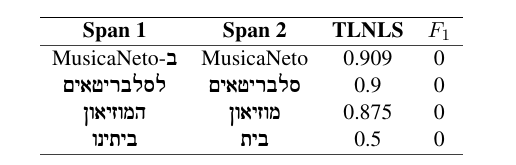

In [75]:
def levenshtein_distance(s: str, t: str) -> int:
    """Compute Levenshtein edit distance between two strings."""
    m, n = len(s), len(t)
    # initialize DP matrix
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if s[i - 1] == t[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,      # deletion
                dp[i][j - 1] + 1,      # insertion
                dp[i - 1][j - 1] + cost   # substitution
            )
    return dp[m][n]

def normalized_lev_similarity(a: str, b: str) -> float:
    """
    Normalized Levenshtein Similarity between two tokens:
    ls(a, b) = 1 - lev(a, b) / max(len(a), len(b))
    """
    if len(a) == 0 and len(b) == 0:
        return 1.0
    lev = levenshtein_distance(a, b)
    return 1.0 - lev / max(len(a), len(b))

def token_level_normalized_lev_similarity(pred: str, gold: str) -> float:
    """
    TLNLS between two Hebrew strings.
    Tokenize by whitespace, compute similarity token-wise.
    """
    # Tokenize inputs
    pred_tokens = pred.split()
    gold_tokens = gold.split()

    if len(pred_tokens) == 0 and len(gold_tokens) == 0:
        return 1.0

    # For each gold token find best matching pred token
    total_similarity = 0.0
    for g in gold_tokens:
        best = 0.0
        for p in pred_tokens:
            score = normalized_lev_similarity(g, p)
            if score > best:
                best = score
        total_similarity += best

    # Divide by maximum number of tokens
    norm_factor = max(len(gold_tokens), len(pred_tokens))
    return total_similarity / norm_factor


pred = "בית"
gold = "ביתינו"

score = token_level_normalized_lev_similarity(pred, gold)
print(f"TLNLS similarity: {score:.4f}")


pred = "המוזיאון"
gold = "מוזיאון"

score = token_level_normalized_lev_similarity(pred, gold)
print(f"TLNLS similarity: {score:.4f}")

TLNLS similarity: 0.5000
TLNLS similarity: 0.8750


In [76]:
import re

def extract_shortest_span(predicted_answer: str, true_answers: list) -> str:
    """
    מנסה לחלץ מהתשובה של המודל את ה-span הקצר ביותר
    שתואם לאחת התשובות האמיתיות.
    אם לא מצליח, מחזיר את predicted_answer אחרי ניקוי בסיסי.
    """
    # ניקוי בסיסי
    answer = predicted_answer.strip()
    answer = re.sub(r'\[.*?\]|\(.*?\)|\.\.\.', '', answer)
    answer = re.sub(r'^[\"\']|[\"\']$', '', answer)

    # מחפש את אחת התשובות האמיתיות בתוך הטקסט
    for true_ans in true_answers:
        pattern = re.escape(true_ans.strip())
        match = re.search(pattern, answer)
        if match:
            return match.group(0)  # מחזיר בדיוק את הטקסט שהתקבל
    # אם לא נמצא, מחזיר את הטקסט שנוקה
    return answer


יש אופציה "להעניש" את המודל אם התשובה לא קיימת והמודל המציא תשובה, כרגע אנחנו פשוט נותנים ציון 0

In [78]:
import json
import requests
import re
from typing import List, Dict

# =========================
# CONFIG
# =========================

DATASET_PATH = "hebrew_qa.json"  # הנתונים שלך
PERPLEXITY_MODEL = "sonar-pro"
PERPLEXITY_URL = "https://api.perplexity.ai/chat/completions"
PERPLEXITY_API_KEY  = "YOUR API KEY"
SLEEP = 1.0

# =========================
# LOAD DATASET
# =========================
def load_dataset(path: str, limit: int = None) -> List[Dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    samples = []
    for entry in data["data"]:
        for para in entry["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                samples.append({
                    "context": context,
                    "question": qa["question"],
                    "answers": [a["text"] for a in qa.get("answers", [])],
                    "is_impossible": qa.get("is_impossible", False)
                })
    if limit:
        return samples[:limit]
    return samples

# =========================
# CALL PERPLEXITY QA
# =========================
def call_perplexity_qa(context: str, question: str, few_shot_example: str) -> str:
    prompt = f"""
אתה מומחה ב-Hebrew QA. עקוב אחרי הפורמט:
{few_shot_example}

כעת הטקסט:
Context: {context}

שאלה: {question}

אם אין תשובה בטקסט – כתוב 'Unanswerable'. אחרת – כתוב רק את ה-span המדויק מהטקסט.
"""
    headers = {
        "Authorization": f"Bearer {PERPLEXITY_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": PERPLEXITY_MODEL,
        "messages": [
            {"role": "system", "content": "You are a precise Hebrew Extractive QA model with reasoning."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.0,
    }

    try:
        r = requests.post(PERPLEXITY_URL, headers=headers, json=payload, timeout=300)
        r.raise_for_status()
        text = r.json()["choices"][0]["message"]["content"].strip()

        # חילוץ התשובה אחרי 'A:' או השורה האחרונה
        match = re.search(r"A\s*:\s*(.+)", text, flags=re.DOTALL)
        if match:
            answer = match.group(1).strip()
            answer = re.sub(r'^["\']|["\']$', '', answer)
            return answer
        lines = [l.strip() for l in text.splitlines() if l.strip()]
        if lines:
            return lines[-1]
        return "Unanswerable"
    except Exception as e:
        print("⚠️ שגיאה בקריאה ל-Perplexity:", e)
        return "Unanswerable"

# =========================
# TLNLS METRIC (UPDATED)
# =========================
def levenshtein_distance(s: str, t: str) -> int:
    m, n = len(s), len(t)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if s[i - 1] == t[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )
    return dp[m][n]

def normalized_lev_similarity(a: str, b: str) -> float:
    if len(a) == 0 and len(b) == 0:
        return 1.0
    lev = levenshtein_distance(a, b)
    return 1.0 - lev / max(len(a), len(b))

def token_level_normalized_lev_similarity(pred: str, gold: str) -> float:
    pred_tokens = pred.split()
    gold_tokens = gold.split()
    if len(pred_tokens) == 0 and len(gold_tokens) == 0:
        return 1.0
    total_similarity = 0.0
    for g in gold_tokens:
        best = 0.0
        for p in pred_tokens:
            score = normalized_lev_similarity(g, p)
            if score > best:
                best = score
        total_similarity += best
    norm_factor = max(len(gold_tokens), len(pred_tokens))
    return total_similarity / norm_factor

# =========================
# RUN EVALUATION
# =========================
def run_hebrew_qa_evaluation(limit: int = 10):
    dataset = load_dataset(DATASET_PATH, limit=limit)

    few_shot_example = """
Context: "הספרייה הלאומית הוקמה בשנת 1892 ומכילה אוספים רבים של ספרים ועיתונים."
Q: מתי הוקמה הספרייה הלאומית?
A: בשנת 1892

Context: "תכנית החלל של ישראל התחילה בשנת 1983 ונועדה לפתח לוויינים."
Q: מהי מטרת תכנית החלל של ישראל?
A: לפתח לוויינים

Context: "ביום ראשון התחוללה סערה קשה באזור הצפון."
Q: מה קרה ביום ראשון באזור הצפון?
A: סערה קשה
"""
    total_score = 0.0

    for idx, sample in enumerate(dataset, 1):
        context = sample["context"]
        question = sample["question"]
        true_answers = sample["answers"] if not sample["is_impossible"] else ["Unanswerable"]

        #predicted_answer = call_perplexity_qa(context, question, few_shot_example)

        # במידה רוצים לקבל את התשובה הנכונה מתוך התשובה הכוללת

        predicted_raw = call_perplexity_qa(context, question, few_shot_example)
        predicted_answer = extract_shortest_span(predicted_raw,true_answers)

        # חישוב TLNLS עם הפונקציה המעודכנת
        best_score = max([token_level_normalized_lev_similarity(predicted_answer, ta) for ta in true_answers])
        total_score += best_score

        print(f"\n===== Sample {idx} =====")
        print("Question:", question)
        print("True Answer(s):", true_answers)
        print("Predicted Answer:", predicted_answer)
        print(f"TLNLS score: {best_score:.3f}")

    avg_score = total_score / len(dataset)
    print("\n===== FINAL TLNLS SCORE =====")
    print(f"Average TLNLS: {avg_score:.3f}")

# =========================
# RUN
# =========================
if __name__ == "__main__":
    run_hebrew_qa_evaluation(limit=15)



===== Sample 1 =====
Question: כמה אנשים היו בוועדה שניסחה את הטיוטה הרביעית?
True Answer(s): ['חמישה']
Predicted Answer: חמישה
TLNLS score: 1.000

===== Sample 2 =====
Question: באילו מילים התחילו כל סעיפי הטויוטה?
True Answer(s): ['הואיל ו']
Predicted Answer: הואיל ו
TLNLS score: 1.000

===== Sample 3 =====
Question: איזו תוכנית הוכרזה כחלק מההצעה של הטיוטה?
True Answer(s): ['תוכנית החלוקה של האו"ם']
Predicted Answer: תוכנית החלוקה של האו"ם
TLNLS score: 1.000

===== Sample 4 =====
Question: מי היה נשיא המדינה בזמן חתימת המגילה?
True Answer(s): ['חיים ויצמן']
Predicted Answer: Unanswerable
TLNLS score: 0.000

===== Sample 5 =====
Question: שמו של איזה חותם מגילה מגיע מיד אחרי ויצמן בסדר אלפביתי?
True Answer(s): ['מאיר וילנר']
Predicted Answer: מאיר וילנר
TLNLS score: 1.000

===== Sample 6 =====
Question: היכן חתם בן-גוריון על המגילה?
True Answer(s): ['בראש החותמים']
Predicted Answer: Unanswerable
TLNLS score: 0.000

===== Sample 7 =====
Question: היכן היה ויצמן בזמן חתימת המגילה?
Tru

#  Adapt to vllm

In [ ]:
import json
import re
import time
from typing import List, Dict
from openai import OpenAI

# =========================
# CONFIG
# =========================

DATASET_PATH = "hebrew_qa.json"
VLLM_BASE_URL = "http://localhost:8000/v1"
MODEL_NAME = "your-model-name"   # למשל: aya-23, gemma, mistral וכו'
SLEEP = 1.0

client = OpenAI(
    base_url=VLLM_BASE_URL,
    api_key="EMPTY"  # vLLM לא דורש מפתח, אבל הספרייה מחייבת ערך
)

# =========================
# LOAD DATASET
# =========================

def load_dataset(path: str, limit: int = None) -> List[Dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    samples = []
    for entry in data["data"]:
        for para in entry["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                samples.append({
                    "context": context,
                    "question": qa["question"],
                    "answers": [a["text"] for a in qa.get("answers", [])],
                    "is_impossible": qa.get("is_impossible", False)
                })

    return samples[:limit] if limit else samples

# =========================
# CALL vLLM QA (OpenAI API)
# =========================

def call_vllm_qa(context: str, question: str, few_shot_example: str) -> str:
    prompt = f"""
אתה מודל Hebrew Extractive QA.

{few_shot_example}

Context:
{context}

שאלה:
{question}

אם אין תשובה בטקסט – כתוב "Unanswerable".
אחרת – החזר רק את ה-span המדויק מתוך הטקסט, ללא הסברים.
"""

    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "You are a precise Hebrew Extractive QA model."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            max_tokens=128,
        )

        text = response.choices[0].message.content.strip()

        # ניקוי תשובה
        lines = [l.strip() for l in text.splitlines() if l.strip()]
        return lines[-1] if lines else "Unanswerable"

    except Exception as e:
        print("⚠️ שגיאה בקריאה ל-vLLM:", e)
        return "Unanswerable"

# =========================
# TLNLS METRIC
# =========================

def levenshtein_distance(s: str, t: str) -> int:
    m, n = len(s), len(t)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if s[i - 1] == t[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )
    return dp[m][n]

def normalized_lev_similarity(a: str, b: str) -> float:
    if not a and not b:
        return 1.0
    return 1.0 - levenshtein_distance(a, b) / max(len(a), len(b))

def token_level_normalized_lev_similarity(pred: str, gold: str) -> float:
    pred_tokens = pred.split()
    gold_tokens = gold.split()

    if not pred_tokens and not gold_tokens:
        return 1.0

    total = 0.0
    for g in gold_tokens:
        best = max(normalized_lev_similarity(g, p) for p in pred_tokens) if pred_tokens else 0.0
        total += best

    return total / max(len(gold_tokens), len(pred_tokens))

# =========================
# RUN EVALUATION
# =========================

def run_hebrew_qa_evaluation(limit: int = 10):
    dataset = load_dataset(DATASET_PATH, limit)

    few_shot_example = """
Context: הספרייה הלאומית הוקמה בשנת 1892.
Q: מתי הוקמה הספרייה הלאומית?
A: בשנת 1892

Context: תכנית החלל של ישראל התחילה בשנת 1983.
Q: מתי התחילה תכנית החלל של ישראל?
A: בשנת 1983
"""

    total_score = 0.0

    for idx, sample in enumerate(dataset, 1):
        context = sample["context"]
        question = sample["question"]
        true_answers = ["Unanswerable"] if sample["is_impossible"] else sample["answers"]

        predicted = call_vllm_qa(context, question, few_shot_example)
        score = max(token_level_normalized_lev_similarity(predicted, gt) for gt in true_answers)

        total_score += score

        print(f"\n===== Sample {idx} =====")
        print("Question:", question)
        print("True Answer(s):", true_answers)
        print("Predicted Answer:", predicted)
        print(f"TLNLS score: {score:.3f}")

        time.sleep(SLEEP)

    print("\n===== FINAL TLNLS SCORE =====")
    print(f"Average TLNLS: {total_score / len(dataset):.3f}")

# =========================
# RUN
# =========================

if __name__ == "__main__":
    run_hebrew_qa_evaluation(limit=15)
